# Imports

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split

import mne
from mne import Epochs, pick_types, events_from_annotations, set_log_level
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from tqdm.notebook import tqdm

set_log_level("WARNING")
N_PARALLEL=6

# Get Data (1 subject)

In [12]:
REAL = "real"
IMAGINED = "imagined"

LR = 'L vs R'
HAND_FEET = 'Hands vs feet'

tasks = [
    {
        "name": "Real moving hands",
        "real": True,
        "type": LR,
        "runs": [3, 7, 11],
        "labels": {0: "rest", 1: "left hand", 2: "right hand"},
    },
    {
        "name": "Imagine moving hands",
        "real": False,
        "type": LR,
        "runs": [4, 8, 12],
        "labels": {0: "rest", 1: "imagine left hand", 2: "imagine right hand"},
    },
    {
        "name": "move hands vs feet",
        "real": True,
        "type": HAND_FEET,
        "runs": [5, 9, 13],
        "labels": {0: "rest", 1: "hands", 2: "feet"},
    },
    {
        "name": "imagine hands vs feet",
        "real": False,
        "type": HAND_FEET,
        "runs": [6, 10, 14],
        "labels": {0: "rest", 1: "imagine both hands", 2: "imagine both feet"},
    }
]

task_number = 0
subject = 1

tmin, tmax = -1., 4.
noisy_channels = ['AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'Fp1', 'Fpz', 'Fp2', 'P7', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6',
                    'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'Iz']

def get_epochs(task_number: int, subject_number: int, tmin: float = -1., tmax: float = 4.0, montage_name: str = 'standard_1005', noisy_channels: List[str] = noisy_channels) -> Epochs:
    runs = tasks[task_number]['runs']
    labels = tasks[task_number]["labels"]

    print(f"Getting epochs for {tasks[task_number]['name']} {subject_number = }.")

    raw_fnames = eegbci.load_data(subject_number, runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    eegbci.standardize(raw)  # set channel names
    montage = make_standard_montage(montage_name)
    raw.set_montage(montage)

    events, _ = mne.events_from_annotations(raw, event_id=dict(T1=1, T2=2))
    annotations = mne.annotations_from_events(events=events, event_desc=labels, sfreq=raw.info["sfreq"])

    raw.drop_channels(noisy_channels)
    raw.notch_filter(60, method="iir")
    raw.filter(7.0, 32.0, fir_design="firwin", skip_by_annotation="edge")

    events, event_ids = mne.events_from_annotations(raw)
    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,exclude=noisy_channels)
    epochs = Epochs(raw, events, event_ids, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)

    return epochs

In [56]:
def cross_val_pipeline(pipeline, epochs) -> float:
    targets = epochs.events[:, -1]
    epochs_data = epochs.copy().crop(tmin=1.0, tmax=4.0).get_data() # They do this cropping on MNE website. Why ?

    scores = cross_val_score(pipeline, epochs_data, targets, cv=ShuffleSplit(10, test_size=0.2), n_jobs=None)
    print(f"Cross validation average {scores.mean():.2f}")
    return scores.mean()


def train_pipeline(pipeline, epochs) -> Pipeline:
    targets = epochs.events[:, -1]
    epochs_data = epochs.copy().crop(tmin=1.0, tmax=4.0).get_data() # They do this cropping on MNE website. Why ?

    x_train, x_test, y_train, y_test = train_test_split(epochs_data, targets, test_size=0.1, random_state=0)

    x_train, y_train = epochs_data, targets
    pipeline.fit(X=x_train, y=y_train)
    score = pipeline.score(X=x_test, y=y_test)
    print(f"trained_pipeline_score: {score:.2f}")

    return pipeline


# print()
e = get_epochs(task_number=0, subject_number=16)

csp = CSP(n_components=4)
lda_shrimp = LDA(solver='lsqr', shrinkage='auto')
pipeline = Pipeline([("CSP", csp), ("LDA", lda_shrimp)])

score = cross_val_pipeline(pipeline, e)
trained_pipeline = train_pipeline(pipeline, e)
print(score)


Cross validation average 0.76
trained_pipeline_score: 0.67
0.7611111111111112


In [62]:
number_of_subjects = 4
models = ['classic', 'shrimp']
results = {}

def build_pipe(model: str = 'classic') -> Pipeline:
    if (model == 'shrimp'):
        csp = CSP(n_components=4)
        lda_shrimp = LDA(solver='lsqr', shrinkage='auto')
        pipeline = Pipeline([("CSP", csp), ("LDA", lda_shrimp)])
    else if model == 'classic':
        csp = CSP(n_components=4)
        lda = LDA()
        pipeline = Pipeline([("CSP", csp), ("LDA", lda)])
    return pipeline



for model in models:
    print("training model ", model)
    metrics = {}
    results[model] = metrics
    for task_number in range(4):
        task = tasks[task_number]
        metrics[f"{task['name']}"] = cross_val_scores
        print(f"Starting model training for task {task['name']}")
        for subject in tqdm(range(1, number_of_subjects + 1)):
            epochs = get_epochs(task_number, subject)
            pipe = build_pipe(model=model)
            cross_val_scores.append(cross_val_pipeline(pipe, epochs))
            # trained_pipeline = train_pipeline(pipe, epochs)



SyntaxError: invalid syntax (4076240604.py, line 10)

# Define Pipeline & Cross validation

In [59]:

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
# scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=None)
scores = cross_val_score(clf, epochs_data_stak, labels_stak, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))


Classification accuracy: 0.544856 / Chance level: 0.511111


# Training

In [60]:
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
clf = Pipeline([('CSP', csp), ('LDA', lda)])
epochs_data = epochs.get_data()
epochs_data.shape

(45, 64, 801)

In [61]:
from tqdm import tqdm

sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

cv_split = cv.split(epochs_data_stak)
train_indexes, test_indexes = next(cv_split)

scores = []
for i in tqdm(range(10)):
    # y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_stak[train_indexes], labels_stak[train_indexes])
    X_test = csp.transform(epochs_data_stak[test_indexes])

    # fit classifier
    lda.fit(X_train, labels_stak[train_indexes])
    scores.append(lda.score(X_test, labels_stak[test_indexes]))
    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data_stak[test_indexes][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, labels_stak[test_indexes]))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
# plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.plot(scores, label='Scores')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

 50%|█████     | 5/10 [00:31<00:31,  6.23s/it]

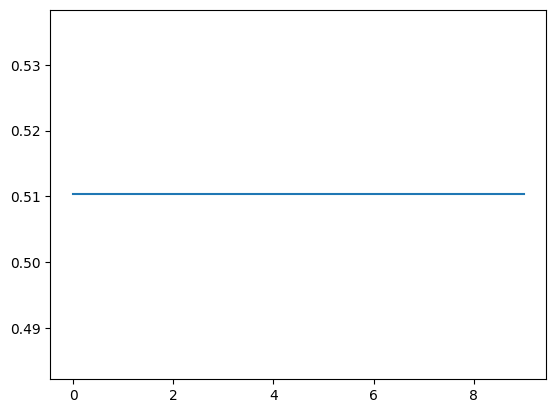

In [ ]:
plt.plot(scores, label='Scores')
